We perform demand predictions for __SKU configs within groups__ (determined by [sub-category, gender, season], e.g., [shirts, male, spring-summer] is a group). We currently have 700+ such groups in our data. However, 25% of groups have less than 5 configs, too few data, and half of them have less than 20 configs (see stats + histogram). Thus, we will first look at the more interesting upper half of groups, where each group has at least 20 configs.

# Inits

In [1]:
# load std modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xgboost as xgb
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from matplotlib.pyplot import Line2D

In [4]:
# various dirs
DAT_DIR = '/Users/gfg/data/venture=Zalora/sg/'
CLEAN_DIR = DAT_DIR + 'clean/'; FIG_DIR = DAT_DIR + 'fig/'
GROUP_DIR = CLEAN_DIR + 'groups/'; FEAT_DIR = GROUP_DIR + 'feats/'

In [4]:
# my own modules
import date_util
import input_load
import split
import model_train
from model_train import *

In [5]:
in_loader = InputLoader(DataPrep())
data_splitter = DataSplitter(split_ratio=80)
out_dumper = OutDumper()

2017-11-27 10:05:39 GFG20170005.local root[5490] INFO Loading global feats in yr 2017 from file /Users/gfg/data/venture=zalora/sg/clean/2017/glob_feat.csv...
2017-11-27 10:06:10 GFG20170005.local root[5490] INFO Loading historical sales from /Users/gfg/data/venture=zalora/sg/clean/demand_config.csv...


In [9]:
model_trainer = ModelTrainer(model_dir=out_dumper.model_dir)

In [ ]:
# reload for updates
reload(date_util); from date_util import *
reload(input_load); from input_load import *
reload(split); from split import *

In [41]:
reload(model_train); from model_train import *

## Utils

In [36]:
# list functions of an object
def get_funcs(obj):
    return [method_name for method_name in dir(obj) if callable(getattr(obj, method_name))]

## Distribution of group sizes

In [ ]:
def size_hist(group_df):
    pl.figure(figsize = (10, 5))
    pl.hist(group_df['n_config'], bins=50)
    ax = pl.gca()
    ax.minorticks_on()
    pl.xlabel('# configs in group'); pl.ylabel('# groups')
    pl.grid(True, ls='--')
    pl.savefig(FIG_DIR + 'group_size_hist.pdf')
    pl.show(); pl.close()

In [ ]:
group_df = pd.read_csv(CLEAN_DIR + 'groups.csv')
group_df.n_config.describe()

In [ ]:
size_hist(group_df)

Each group is associated with one feature matrix, which is composed from __global__ features (e.g. color/size/brand popularities) and __group__ features (e.g. price, discount, relative price,...).

# Build ready data

Steps to prepare ready data for each group:

+ Load global feats
+ Form feature matrix: by joining group feats with global feats
+ Obtain final ready data: by attaching response to the feature matrix
+ Split training and test sets by date: currently, for each config, we use about $20\%$ of its data for testing and all data before that for training.

The methods to perform these steps are defined in section `Helpers` of this notebook.

# Helpers

## Features 

In [8]:
feats = ['current_price', 'discount_from_rrp', 'n_competitor', 'rel_price', 'color_pop', 
         'mean_views', 'mean_impressions', 'total_views', 'total_impressions',
        'is_weekend', 'is_workday'] # brand_pop

print('# features: {}'.format(len(feats)))

# features: 11


__Note:__ most features are dynamic, except color/size popularities which are almost static.

## Suggestions from Zalora team:

 
+ shift in a time window to catch the trend
+ statistical feats from main feature (median, min, max,...)
+ features: Add to cart, purchased
+ use `shipment == outright`
+ mix local model with global model e.g. global min,...
+ change from daily to weekly prediction
+ delay in data
+ available stock 
+ monthly offline meeting

### Scaling
Currently feats are not rescaled to zero mean and unit variance.

From Hieu: scaling is not that important for `xgboost`, it is only important for SVM. 

## Models and CV Settings

We will compare performance of the following regression models in __demand prediction__ task:

* Lasso: linear with $L_1$ penalty to drive for sparse weights (if we expect them to be sparse, i.e., just few of them are non-zero)
* Bagging Regression Tree (BRT)
* Random Forest
* XGBoost Regressor

## Exp Helpers

In [6]:
def run_exp(gname, feats):
    ready_df = prep_data(gname)
    print()
    
    train_df, test_df = split_train_test(ready_df)
    rmse_df, predictions = fit_predict(models, train_df, test_df)
    return rmse_df, predictions

def cols_to_show(pred):
    pred_cols = [c for c in pred.columns if 'predict_' in c]
    diff_cols = [c for c in pred.columns if 'diff_' in c]
    abs_cols = [c for c in pred.columns if 'abs_' in c]
    cols = ['sku_config', 'product_name', 'brand_name'] + ['n_sold'] + pred_cols + diff_cols + abs_cols
    return cols

def evaluate(predictions, cf='MA193AA06RQJMY', fig_size=(10, 5)):
    
    cf_pred = predictions.query('sku_config == "{}"'.format(cf)).copy()
    
    # diff bw predict and actual
    for m in list(map(stdize, model_names)):
        cf_pred['diff_{}'.format(m)] = cf_pred['predict_{}'.format(m)] - cf_pred['n_sold']
        cf_pred['abs_diff_{}'.format(m)] = np.abs(cf_pred['diff_{}'.format(m)])
        
    
    prod_name = cf_pred['product_name'].iloc[0]
    fig = viz(predictions, cf, prod_name, fig_size)
    return cf_pred, fig

In [7]:
def inspect_results(cf, cols=None):
    cf_pred, fig = evaluate(predictions, cf, fig_size=(16, 8))
    pl.show(); pl.close()
    print()
    print('Samples of prediction:')
    return cf_pred.sort_values('n_sold', ascending=False).head(10) # [cols]

In [8]:
# columns to inspect
rf_cols = ['predict_random_forest', 'diff_random_forest', 'abs_diff_random_forest']
cols = ['sku_config', 'product_name', 'brand_name'] + ['n_sold'] + rf_cols

## Visualization

In [ ]:
def init_fig(size=(5, 5), use_avg=False):
    fig = pl.figure(figsize=size)
    ylab = 'Demand' if not use_avg else 'Avg. Demand'
    pl.ylabel(ylab)
    pl.grid(True, ls='--')
    fig.autofmt_xdate()
    return fig

def get_markers(models):
    markers = list(Line2D.markers.keys())
    markers.remove('o')
    return markers[:len(models)]

def do_viz(pred_df, use_avg=False, fig_size=(10, 5)):
    fig = init_fig(fig_size, use_avg)
    dates = pred_df['date']
    y_test = pred_df['n_sold'] if not use_avg else pred_df['avg_n_sold']
    pl.set_cmap('Set1')
    pl.plot(dates, y_test, marker='o', ls='-')
    
    markers = get_markers(models)
    for i in range(len(models)):
        m_name = stdize(model_names[i])
        col = 'predict_{}'.format(m_name) if not use_avg else ('avg_' + 'predict_{}'.format(m_name))
        y_pred = pred_df[col]
        pl.plot(dates, y_pred, marker=markers[i])
    
    pl.legend(['Actual'] + model_names)
    return fig

def viz(predictions, cf, prod_name, fig_size=(10, 5)):
    
    cf_pred = predictions.query('sku_config == "{}"'.format(cf))
    fig = do_viz(cf_pred)
    pl.title('Demand predictions for SKU config: {0} ({1})'.format(cf, prod_name))
    return fig

# Autumn-winter products

## Female dresses

In [21]:
from pandas.plotting import scatter_matrix

### Analyze features

In [33]:
feats = ['current_price', 'discount_from_rrp', 'n_competitor', 'rel_price', 'color_pop', 
         'mean_views', 'mean_impressions', 
        'is_weekend', 'is_workday'] # brand_pop, 'total_views', 'total_impressions',

len(feats)

9

In [54]:
names = ['price', 'discount', 'competitors', 'r_price', 'c_pop', 
         'm_views', 'm_impressions', 
         'weekend', 'workday']

In [52]:
train_df, test_df = in_loader.mk_train_test(data_splitter, group='dresses_female_autumn-winter')

2017-11-27 15:58:48 GFG20170005.local root[5490] INFO Building feature matrix of group dresses_female_autumn-winter...
2017-11-27 15:58:48 GFG20170005.local root[5490] INFO Loading features of group dresses_female_autumn-winter from /Users/gfg/data/venture=zalora/sg/clean/groups/feats/dresses_female_autumn-winter.csv...
2017-11-27 15:58:49 GFG20170005.local root[5490] INFO 	 dropped NA configs


	 Adding is_weekend feature...


2017-11-27 15:58:54 GFG20170005.local root[5490] INFO Saved ready data to file /Users/gfg/data/venture=zalora/sg/clean/groups/feats/ready_df_dresses_female_autumn-winter.csv


Extracting train data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
	900 configs and counting...
	1000 configs and counting...
Extracting test data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
	900 configs and counting...
	1000 configs and counting...


In [55]:
train_df.rename(columns=dict(zip(feats, names)), inplace=True)
test_df.rename(columns=dict(zip(feats, names)), inplace=True)

In [56]:
corr = train_df[names].corr()
corr

,price,discount,competitors,r_price,c_pop,m_views,m_impressions,weekend,workday
price,1.000000,-0.004122,0.209739,0.121712,0.009330,0.004266,0.004589,0.014629,-0.014629
discount,-0.004122,1.000000,-0.004867,-0.289498,-0.064262,-0.170012,-0.131865,-0.030524,0.030524
competitors,0.209739,-0.004867,1.000000,-0.119467,0.061088,-0.088770,-0.090021,0.013504,-0.013504
r_price,0.121712,-0.289498,-0.119467,1.000000,0.088163,-0.284400,-0.179194,0.018990,-0.018990
c_pop,0.009330,-0.064262,0.061088,0.088163,1.000000,-0.026133,-0.007536,0.001088,-0.001088
m_views,0.004266,-0.170012,-0.088770,-0.284400,-0.026133,1.000000,0.894552,0.267754,-0.267754
m_impressions,0.004589,-0.131865,-0.090021,-0.179194,-0.007536,0.894552,1.000000,0.198608,-0.198608
weekend,0.014629,-0.030524,0.013504,0.018990,0.001088,0.267754,0.198608,1.000000,-1.000000
workday,-0.014629,0.030524,-0.013504,-0.018990,-0.001088,-0.267754,-0.198608,-1.000000,1.000000


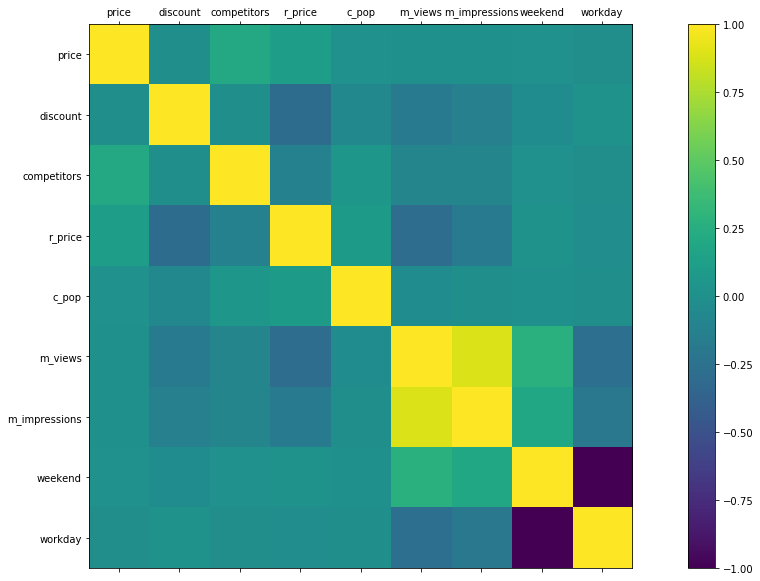

In [59]:
# plot correlation matrix
fig = pl.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(names), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
pl.show()

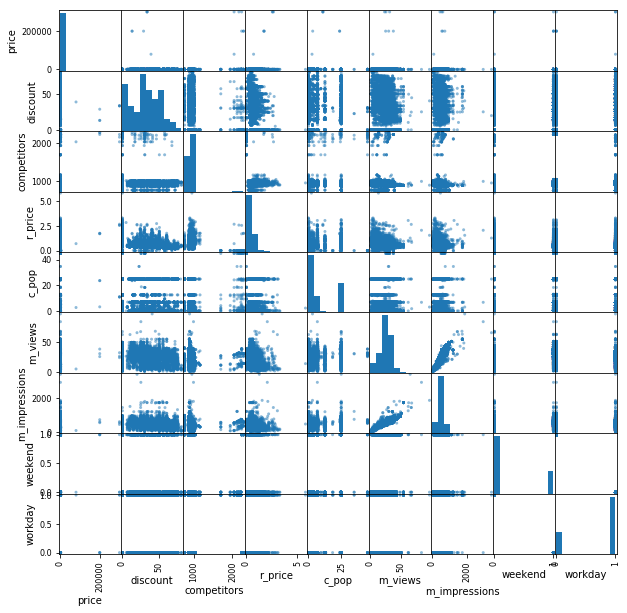

In [60]:
scatter_matrix(train_df[names], figsize=(10, 10))
pl.show()

### Train & Predict

In [15]:
fem_dress_aw_train, fem_dress_aw_test, sorted_models_df = model_trainer.benchmark(group='dresses_female_autumn-winter', 
                                                              in_loader=in_loader, out_dumper=out_dumper)
print('Models sorted by test RMSE:')
print(sorted_models_df)

2017-11-23 14:33:54 GFG20170005.local root[918] INFO Building feature matrix of group dresses_female_autumn-winter...
2017-11-23 14:33:54 GFG20170005.local root[918] INFO Loading features of group dresses_female_autumn-winter from /Users/gfg/data/venture=zalora/sg/clean/groups/feats/dresses_female_autumn-winter.csv...
2017-11-23 14:33:54 GFG20170005.local root[918] INFO 	 dropped NA configs


	 Adding is_weekend feature...


2017-11-23 14:33:59 GFG20170005.local root[918] INFO Saved ready data to file /Users/gfg/data/venture=zalora/sg/clean/groups/feats/ready_df_dresses_female_autumn-winter.csv


Extracting train data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
	900 configs and counting...
	1000 configs and counting...
Extracting test data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
	900 configs and counting...
	1000 configs and counting...
Fitting models to training data...

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/gfg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


0.0154572136492
{'alpha': 10.0}

Performing CV for ridge_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-1571.41874219
{'alpha': 10.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.7min finished


-0.0284532863718
{'max_depth': 3, 'n_estimators': 10}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.6min finished


-0.0406881115231
{'max_depth': 3, 'n_estimators': 100}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   46.6s finished


-0.00701222963782
{'max_depth': 3, 'n_estimators': 20}
Saving predictions to file /Users/gfg/projects/daas-markdown/res/dresses_female_autumn-winter_predict.csv...
Models sorted by test RMSE:
                     model  test_rmse  train_rmse
0         Lasso Regression   0.998235    1.119120
2  Boosted Regression Tree   1.006279    1.089425
4                  XGBoost   1.006532    1.076096
1         Ridge Regression   1.006849    1.110379
3            Random Forest   1.023388    1.090303


Compared with accuracy of models by DataRobot, ours are a bit worse. It is expected as:
+ we use less features
+ our models are simpler, theirs are much more complicated, for example they blend 5-6 models which are already strong. Basically, theirs are meta/hyper models i.e. models which are combinations of several models.

We can also build meta models ourselves.

### Feature importance

In [16]:
best_xgboost = model_trainer.best_models[-1].best_estimator_

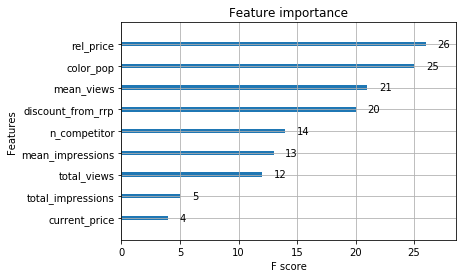

In [18]:
fig = xgb.plot_importance(best_xgboost)
pl.show()

## Female jewellery

### Train & Predict

In [23]:
fem_jewel_aw_train, fem_jewel_aw_test, sorted_models_df = model_trainer.benchmark(group='jewellery_female_autumn-winter', 
                                                              in_loader=in_loader, out_dumper=out_dumper)
print('Models sorted by test RMSE:')
print(sorted_models_df)

2017-11-23 15:02:38 GFG20170005.local root[918] INFO Building feature matrix of group jewellery_female_autumn-winter...
2017-11-23 15:02:38 GFG20170005.local root[918] INFO Loading features of group jewellery_female_autumn-winter from /Users/gfg/data/venture=zalora/sg/clean/groups/feats/jewellery_female_autumn-winter.csv...
2017-11-23 15:02:38 GFG20170005.local root[918] INFO 	 dropped NA configs
2017-11-23 15:02:42 GFG20170005.local root[918] INFO Saved ready data to file /Users/gfg/data/venture=zalora/sg/clean/groups/feats/ready_df_jewellery_female_autumn-winter.csv


	 Adding is_weekend feature...
Extracting train data...
Extracting test data...
Fitting models to training data...

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-0.0191626818249
{'alpha': 10.0}

Performing CV for ridge_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-0.85672694665
{'alpha': 10.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    2.3s finished


-0.198027587827
{'max_depth': 3, 'n_estimators': 10}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.7s finished


-0.171446574519
{'max_depth': 3, 'n_estimators': 10}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
-0.362427506591
{'max_depth': 3, 'n_estimators': 20}
Saving predictions to file /Users/gfg/projects/daas-markdown/res/jewellery_female_autumn-winter_predict.csv...
Models sorted by test RMSE:
                     model  test_rmse  train_rmse
3            Random Forest   0.444134    0.215435
0         Lasso Regression   0.446736    0.285052
2  Boosted Regression Tree   0.464644    0.197133
4                  XGBoost   0.478390    0.195566
1         Ridge Regression   0.563043    0.282468


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    1.8s finished


### Feat importance

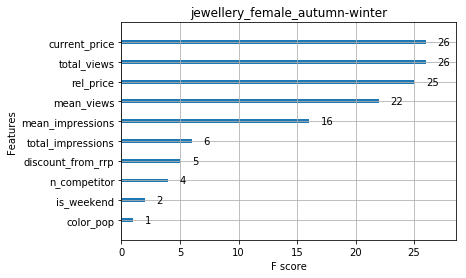

In [24]:
best_xgboost = model_trainer.best_models[-1].best_estimator_
fig = xgb.plot_importance(best_xgboost)
pl.title('jewellery_female_autumn-winter')
pl.show()

## Male t-shirts autumn-winter

In [12]:
male_tshirt_aw_train, male_tshirt_aw_test, sorted_models_df = model_trainer.benchmark(group='t-shirts_male_autumn-winter', 
                                                              in_loader=in_loader, out_dumper=out_dumper)
print('Models sorted by test RMSE:')
print(sorted_models_df)

2017-11-23 16:24:40 GFG20170005.local root[1842] INFO Building feature matrix of group t-shirts_male_autumn-winter...
2017-11-23 16:24:40 GFG20170005.local root[1842] INFO Loading features of group t-shirts_male_autumn-winter from /Users/gfg/data/venture=zalora/sg/clean/groups/feats/t-shirts_male_autumn-winter.csv...
2017-11-23 16:24:41 GFG20170005.local root[1842] INFO 	 dropped NA configs


	 Adding is_weekend feature...


2017-11-23 16:24:45 GFG20170005.local root[1842] INFO Saved ready data to file /Users/gfg/data/venture=zalora/sg/clean/groups/feats/ready_df_t-shirts_male_autumn-winter.csv


Extracting train data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
Extracting test data...
	100 configs and counting...
	200 configs and counting...
	300 configs and counting...
	400 configs and counting...
	500 configs and counting...
	600 configs and counting...
	700 configs and counting...
	800 configs and counting...
Fitting models to training data...

Performing CV for lasso_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/gfg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gfg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gfg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/gfg/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You 

0.00317190166126
{'alpha': 1.0}

Performing CV for ridge_regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
-55388.628176
{'alpha': 10.0}

Performing CV for boosted_regression_tree...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   28.1s finished


0.101609038284
{'max_depth': 3, 'n_estimators': 80}

Performing CV for random_forest...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   41.4s finished


0.0613459020437
{'max_depth': 3, 'n_estimators': 10}

Performing CV for xgboost...
Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   15.4s finished


0.0528995561082
{'max_depth': 3, 'n_estimators': 100}
Saving predictions to file /Users/gfg/projects/daas-markdown/res/t-shirts_male_autumn-winter_predict.csv...
Models sorted by test RMSE:
                     model  test_rmse  train_rmse
3            Random Forest   0.544835    0.586840
0         Lasso Regression   0.642960    0.701970
1         Ridge Regression   0.656349    0.699199
4                  XGBoost   0.730482    0.509833
2  Boosted Regression Tree   0.753212    0.513025


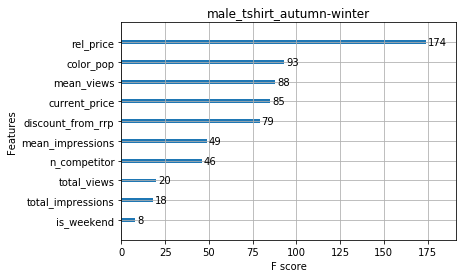

In [13]:
best_xgboost = model_trainer.best_models[-1].best_estimator_
fig = xgb.plot_importance(best_xgboost)
pl.title('male_tshirt_autumn-winter')
pl.show()

# Spring-summer products

## Female heels

In [ ]:
rmse_df, predictions = benchmark(models, feats, group='heels_female_spring-summer')

## Male t-shirts

### Train & Predict

In [ ]:
rmse_df, predictions = benchmark(models, feats, group='t-shirts_male_spring-summer')

### Group level evals

In [ ]:
rmse_df

### Config level evals

## Not enough data in spring-summer 2016
For groups/SKUs in season spring-summer, test data are much larger than training data!!! Because test data start in Apr and end in Jun of 2017, which is actually in season spring-summer2017, while training data start in later half of Apr-2016 and end in March-2017. Train data already include spring-summer of 2016, why so few data.

# Previous code

## Actual avg vs. predicted avg

### Lift charts

In [ ]:
predictions.n_sold.describe()

In [ ]:
fig = pl.figure()
ns, bins, patches = pl.hist(predictions.n_sold, bins=10)
pl.show(); pl.close()

In [ ]:
# select only majority demand values
sel_pred = predictions.query('n_sold <= 5')
fig = pl.figure()
ns, bins, patches = pl.hist(sel_pred.n_sold, bins=10)
pl.show(); pl.close()

In [ ]:
print('Bin info:')
bin_info = pd.DataFrame({'size': ns, 'lower': bins[0: n_bin], 'upper': bins[1:]})
bin_info

In [ ]:
bin_info = bin_info.query('size > 0')
bin_info.reset_index(inplace=True)
del bin_info['index']
bin_info

In [ ]:
# calculate avg of actual vs. avg of predictions in each bin
pred_cols = [c for c in predictions.columns if 'predict_' in c]
cols = ['n_sold'] + pred_cols
def avg_in_bin(i, bin_info):
    
    row = bin_info.iloc[i]
    low, high = row['lower'], row['upper']
    sub_df = predictions.query('{} <= n_sold & n_sold < {}'.format(low, high))[cols]
    if sub_df.empty:
        sub_df = predictions.query('{} < n_sold & n_sold <= {}'.format(low, high))[cols]
        
    avg_df = pd.DataFrame(sub_df.apply(np.mean, axis=0))   
    return avg_df.rename(columns={0: 'n_sold in [{}, {}]'.format(low, high)})

In [ ]:
n_row = bin_info.shape[0]
frames = [avg_in_bin(i, bin_info) for i in range(n_row)]
pd.concat(frames, 'columns')

### Agg by date

In [ ]:
target_cols = ['date'] + ['n_sold'] + [c for c in predictions.columns if 'predict_' in c]
daily_pred = predictions[target_cols].groupby('date')

In [ ]:
daily_avg = daily_pred.agg(np.mean).add_prefix('avg_').reset_index()
del daily_avg['avg_predict_ridge_regression']

In [ ]:
fig = do_viz(daily_avg, use_avg=True, fig_size=(10, 10))
pl.show(); pl.close()

In [ ]:
daily_avg.sort_values('avg_predict_lasso_regression', inplace=True)

In [ ]:
daily_avg.head()

In [ ]:
daily_avg.tail()

## Config level evaluations 
First we need to choose representative configs to inspect. Some criteria:
+ enough training data
+ cover diff range of demand values (high, medium, low)

### Distribution of training data among configs

In [ ]:
size_df = records_by_config(train_df)
print(size_df['count'].describe())

The distribution shows that most configs (75%) have few data points (less than 20). This may be an obstacle to model performance.

In [ ]:
print('SKU configs with largest number of training records:')
print(size_df.head(10).merge(train_df[['sku_config', 'product_name']].drop_duplicates()))

### Range of demand values

In [ ]:
test_df['n_sold'].describe()

This shows that in test data, most of the time, demand values are no more than 2 units/day.

### Specific configs

#### female dresses

In [ ]:
inspect_results(cf='FD2BCAA6F8E071GS')

In [ ]:
inspect_results(cf='MA193AA06RQJMY')

In [ ]:
inspect_results(cf='D50D7AAF27C667GS')

In [ ]:
inspect_results(cf='AE783AAF4A0DE3GS')

#### female tops

In [ ]:
inspect_results(cf='MA193AA07ZKEMY')

In [ ]:
inspect_results(cf='MA193AA55YNOMY')

In [ ]:
inspect_results(cf='AUBXIAA0000097GS')